## Online Experiment:

In [97]:
import pandas as pd

# Load dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# List of columns to compute descriptive stats for
cols = ["OnlineMem", "ResMem"]

# Loop through each column and compute stats
for col in cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    min_val = df[col].min()
    max_val = df[col].max()
    
    print(f"Descriptive stats for '{col}':")
    print(f"  Mean:  {mean_val:.3f}")
    print(f"  SD:    {std_val:.3f}")
    print(f"  Min:   {min_val:.3f}")
    print(f"  Max:   {max_val:.3f}")
    print("-" * 40)

Descriptive stats for 'OnlineMem':
  Mean:  0.838
  SD:    0.121
  Min:   0.511
  Max:   1.000
----------------------------------------
Descriptive stats for 'ResMem':
  Mean:  0.819
  SD:    0.083
  Min:   0.538
  Max:   0.961
----------------------------------------


In [143]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# Load the dataset and filter out specific names
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Function to run a regression model
def run_regression(df, dependent_var, predictors):
    # Standardize predictors before running regression (keeping variable names)
    X = df[predictors].copy()
    scaler = StandardScaler()
    X[predictors] = scaler.fit_transform(X[predictors])
    
    # Add intercept
    X = sm.add_constant(X)
    y = df[dependent_var]
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    return model

# Run multiple regression: Which factor predicts memorability?
regression_results = {}

# Define predictors
predictors_base = ["Contest", "Education", "ProLevel"] 
vis_cols = ["Hue", "Saturation", "Luminance", "Edge_Density", "Subband_Entropy", "Spectral_Energy"]
predictors_all = ["Contest", "Area"] + [col for col in df.columns if "Medium_" in col] + vis_cols

regression_results["Contest Model"] = run_regression(df, "OnlineMem", ["Contest"])
regression_results["Base Model"] = run_regression(df, "OnlineMem", predictors_base)
regression_results["Overall Model"] = run_regression(df, "OnlineMem", predictors_all)

# Create interaction terms for moderation models
df["Contest_Education"] = df["Contest"] * df["Education"]
df["Contest_ProLevel"] = df["Contest"] * df["ProLevel"]
#df["Education_ProLevel"] = df["Education"] * df["ProLevel"]

predictors_moderation_1 = ["Contest", "Education", "Contest_Education"]
predictors_moderation_2 = ["Contest", "ProLevel", "Contest_ProLevel"]
predictors_moderation_3 = ["Contest", "Education", "ProLevel", "Contest_Education", "Contest_ProLevel"]

# Run moderation models
regression_results["Moderation Model 1"] = run_regression(df, "OnlineMem", predictors_moderation_1)
regression_results["Moderation Model 2"] = run_regression(df, "OnlineMem", predictors_moderation_2)
regression_results["Moderation Model 3"] = run_regression(df, "OnlineMem", predictors_moderation_3)

# Print all results
for model_name, model in regression_results.items():
    print(f"### {model_name} ###\n")
    print(model.summary(), "\n\n")

# T-test between memorable (Contest = 1) and forgettable (Contest = 0) pieces
memorable = df[df["Contest"] == 1]["OnlineMem"]
forgettable = df[df["Contest"] == 0]["OnlineMem"]

# Compute means and standard deviations for both groups
memorable_mean = memorable.mean()
memorable_sd = memorable.std()
forgettable_mean = forgettable.mean()
forgettable_sd = forgettable.std()

# Perform the t-test
t_stat, p_value = ttest_ind(memorable, forgettable, equal_var=False)

# Store t-test results along with descriptive statistics
t_test_results = {
    "t-statistic": t_stat,
    "p-value": p_value,
    "Memorable Mean": memorable_mean,
    "Memorable SD": memorable_sd,
    "Forgettable Mean": forgettable_mean,
    "Forgettable SD": forgettable_sd
}

# Display results
t_test_results


### Contest Model ###

                            OLS Regression Results                            
Dep. Variable:              OnlineMem   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.413
Date:                Mon, 31 Mar 2025   Prob (F-statistic):             0.0132
Time:                        15:06:22   Log-Likelihood:                 62.955
No. Observations:                  86   AIC:                            -121.9
Df Residuals:                      84   BIC:                            -117.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8382      0.

{'t-statistic': 2.181282478259072,
 'p-value': 0.036536885819463565,
 'Memorable Mean': 0.8581645859999999,
 'Memorable SD': 0.10445581189930153,
 'Forgettable Mean': 0.7864774521249999,
 'Forgettable SD': 0.14730397526545297}

In [ ]:
# Remove "Contest" from predictor lists
predictors_base_no_contest = ["Area", "Education", "ProLevel"] 
predictors_interaction = ["Education", "ProLevel", "Education_ProLevel"]
df["Education_ProLevel"] = df["Education"] * df["ProLevel"]

# Run separate regressions for memorable (Contest = 1) and forgettable (Contest = 0) artworks

# Split data
df_memorable = df[df["Contest"] == 1]
df_forgettable = df[df["Contest"] == 0]

# Run regressions separately for memorable and forgettable works
regression_results_separate = {}

# Run base model for each group without Contest as a predictor
regression_results_separate["Memorable Base Model"] = run_regression(df_memorable, "OnlineMem", predictors_base_no_contest)
regression_results_separate["Forgettable Base Model"] = run_regression(df_forgettable, "OnlineMem", predictors_base_no_contest)

# Run updated base model (including interaction term) for each group
regression_results_separate["Memorable Interaction Model"] = run_regression(df_memorable, "OnlineMem", predictors_interaction)
regression_results_separate["Forgettable Interaction Model"] = run_regression(df_forgettable, "OnlineMem", predictors_interaction)

# Print results
for model_name, model in regression_results_separate.items():

    print(f"### {model_name} ###\n")
    print(model.summary(), "\n\n")


### Memorable Base Model ###

                            OLS Regression Results                            
Dep. Variable:              OnlineMem   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.409
Date:                Fri, 21 Mar 2025   Prob (F-statistic):              0.249
Time:                        09:50:24   Log-Likelihood:                 54.768
No. Observations:                  62   AIC:                            -101.5
Df Residuals:                      58   BIC:                            -93.03
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8582 

In [ ]:
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

# Reusing the contingency table from the previous analysis
contingency_table = [[19, 8], [62 - 19, 24 - 8]]

# Chi-Square Test for Homogeneity/Independence
chi2_stat, chi2_p_value, chi2_dof, chi2_expected = chi2_contingency(contingency_table)

# Proportion Z-Test
# Success counts and sample sizes for memorable and forgettable categories
success_counts = [19, 8]
sample_sizes = [62, 24]

z_stat, z_p_value = proportions_ztest(success_counts, sample_sizes)

chi2_stat, chi2_p_value, z_stat, z_p_value

## In-Person Experiment:

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

# Load the dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget", "Karen - Contest"])]

# Step 1: Exclude rows with "Exc" in the "Label" column
df = df[df["Label"] != "Exc"]

# Step 2: Create separate data subsets for Mem, Forg, and Foil
df_mem = df[df["Label"] == "Mem"]
df_forg = df[df["Label"] == "Forg"]
df_foil = df[df["Label"] == "Foil"]

# Step 3: Compute Descriptive Statistics for IPMem (Bayes_IP_HR_FAR) Separately
descriptive_stats = {
    "Memorables": df_mem["Bayes_IP_HR_FAR"].describe(),
    "Forgettables": df_forg["Bayes_IP_HR_FAR"].describe(),
    "Foils IP FAR": df_foil["Bayes_IP_HR_FAR"].describe(),
    "Foils Online FAR": df_foil["OnlineFAR"].describe()
}

# Step 4: Perform independent t-test between Mem and Forg
t_stat, p_val = ttest_ind(df_mem["Bayes_IP_HR_FAR"], df_forg["Bayes_IP_HR_FAR"], equal_var=False)

print(f"Mem vs.Forg T-statistic: {t_stat:.3f}")
print(f"Mem vs.Forg P-value: {p_val:.5f}")

# Step 5: Perform paired-sample t-test between online vs. IP FAR for Foils
t_stat_foil, p_val_foil = ttest_rel(df_foil["Bayes_IP_HR_FAR"], df_foil["OnlineFAR"])

print(f"Online vs. IP FAR T-statistic: {t_stat_foil:.3f}")
print(f"Online vs. IP FAR P-value: {p_val_foil:.5f}")

# Convert dictionary of statistics into a DataFrame for better readability
desc_stats_df = pd.DataFrame(descriptive_stats)
desc_stats_df

Mem vs.Forg T-statistic: 5.308
Mem vs.Forg P-value: 0.00002
Online vs. IP FAR T-statistic: 14.915
Online vs. IP FAR P-value: 0.00000


Memorables  Forgettables  Foils IP FAR  Foils Online FAR
count   20.000000     19.000000     44.000000         44.000000
mean     0.889205      0.704147      0.099604          0.024482
std      0.058150      0.140990      0.032303          0.025370
min      0.742424      0.409091      0.053030          0.000000
25%      0.871212      0.640152      0.079545          0.000000
50%      0.890152      0.693182      0.089015          0.023256
75%      0.927083      0.797348      0.121212          0.027976
max      0.969697      0.954545      0.208333          0.088889

In [ ]:
## NOTE! Sample size might be too small for reliable results##

# Compute Pearson's Correlation for Mem and Forg groups separately
import numpy as np
from scipy.stats import pearsonr

# Check the distribution of values in the key columns
mem_distribution = df_mem[["Bayes_IP_HR_FAR", "OnlineHR"]].describe()
forg_distribution = df_forg[["Bayes_IP_HR_FAR", "OnlineHR"]].describe()

# Pearson correlation: IPMem vs OnlineHR for Mem and Forg
pearson_mem = pearsonr(df_mem["Bayes_IP_HR_FAR"], df_mem["OnlineHR"])
pearson_forg = pearsonr(df_forg["Bayes_IP_HR_FAR"], df_forg["OnlineHR"])

# Compute ICC for reliability/consistency measure
import statsmodels.formula.api as smf

# Function to calculate ICC (Intraclass Correlation Coefficient) manually
def compute_icc(df, col1, col2):
    model = smf.ols(f"{col1} ~ {col2}", data=df).fit()
    residuals = model.resid
    mse_between = np.var(df[col2], ddof=1)
    mse_within = np.var(residuals, ddof=1)
    icc_value = mse_between / (mse_between + mse_within)
    return icc_value

# Compute ICC for Mem and Forg groups separately
icc_mem = compute_icc(df_mem, "Bayes_IP_HR_FAR", "OnlineHR")
icc_forg = compute_icc(df_forg, "Bayes_IP_HR_FAR", "OnlineHR")

# Display results
comparison_results = {
    "Memorables Distribution": mem_distribution,
    "Forgettables Distribution": forg_distribution,
    "Pearson Correlation (Mem)": pearson_mem,
    "Pearson Correlation (Forg)": pearson_forg,
    "ICC (Mem)": icc_mem,
    "ICC (Forg)": icc_forg
}

comparison_results

{'Memorables Distribution':        Bayes_IP_HR_FAR   OnlineHR
 count        20.000000  20.000000
 mean          0.889205   0.963382
 std           0.058150   0.022229
 min           0.742424   0.925000
 25%           0.871212   0.951227
 50%           0.890152   0.958723
 75%           0.927083   0.976744
 max           0.969697   1.000000,
 'Forgettables Distribution':        Bayes_IP_HR_FAR   OnlineHR
 count        19.000000  19.000000
 mean          0.704147   0.717414
 std           0.140990   0.095923
 min           0.409091   0.510638
 25%           0.640152   0.680000
 50%           0.693182   0.739130
 75%           0.797348   0.764156
 max           0.954545   0.902439,
 'Pearson Correlation (Mem)': PearsonRResult(statistic=0.08982298286279064, pvalue=0.7064723292172973),
 'Pearson Correlation (Forg)': PearsonRResult(statistic=0.11719386640912163, pvalue=0.6327866500026624),
 'ICC (Mem)': 0.12840776156766026,
 'ICC (Forg)': 0.31941758496992717}

In [ ]:
# Aggregate Mem and Forg into a single "Target" group
df_target = df[df["Label"].isin(["Mem", "Forg"])]

# Compute descriptive statistics for Target and Foil groups
target_distribution = df_target[["Bayes_IP_HR_FAR", "OnlineHR"]].describe()
foil_distribution = df_foil[["Bayes_IP_HR_FAR", "OnlineFAR"]].describe()

# Pearson correlation: IPMem vs OnlineHR for Targets and IPMem vs OnlineFAR for Foils
pearson_target = pearsonr(df_target["Bayes_IP_HR_FAR"], df_target["OnlineHR"])
pearson_foil = pearsonr(df_foil["Bayes_IP_HR_FAR"], df_foil["OnlineFAR"])

# Compute ICC for reliability/consistency measure for Targets and Foils
icc_target = compute_icc(df_target, "Bayes_IP_HR_FAR", "OnlineHR")
icc_foil = compute_icc(df_foil, "Bayes_IP_HR_FAR", "OnlineFAR")

# Display results
comparison_results_target_vs_foil = {
    "Target Distribution": target_distribution,
    "Foil Distribution": foil_distribution,
    "Pearson Correlation (Target)": pearson_target,
    "Pearson Correlation (Foil)": pearson_foil,
    "ICC (Target)": icc_target,
    "ICC (Foil)": icc_foil
}

comparison_results_target_vs_foil

{'Target Distribution':        Bayes_IP_HR_FAR   OnlineHR
 count        39.000000  39.000000
 mean          0.799048   0.843551
 std           0.141024   0.141840
 min           0.409091   0.510638
 25%           0.696970   0.740994
 50%           0.844697   0.925000
 75%           0.899621   0.958723
 max           0.969697   1.000000,
 'Foil Distribution':        Bayes_IP_HR_FAR  OnlineFAR
 count        44.000000  44.000000
 mean          0.099604   0.024482
 std           0.032303   0.025370
 min           0.053030   0.000000
 25%           0.079545   0.000000
 50%           0.089015   0.023256
 75%           0.121212   0.027976
 max           0.208333   0.088889,
 'Pearson Correlation (Target)': PearsonRResult(statistic=0.6239212075860192, pvalue=2.1970047233402443e-05),
 'Pearson Correlation (Foil)': PearsonRResult(statistic=0.34832223410732893, pvalue=0.020499329636112826),
 'ICC (Target)': 0.6235500590781952,
 'ICC (Foil)': 0.41244885015146465}

In [ ]:
# Define function to check HDI interval overlap
def check_hdi_overlap(df):
    """
    Checks for overlapping HDI intervals within a dataset.
    Returns a percentage of overlapping intervals.
    """
    n = len(df)
    overlaps = 0

    for i in range(n):
        for j in range(i + 1, n):
            lower1, upper1 = df.iloc[i]["Lower_HDI"], df.iloc[i]["Upper_HDI"]
            lower2, upper2 = df.iloc[j]["Lower_HDI"], df.iloc[j]["Upper_HDI"]

            # Check for overlap
            if not (upper1 < lower2 or upper2 < lower1):
                overlaps += 1

    total_comparisons = (n * (n - 1)) / 2  # Number of unique pairs
    overlap_percentage = (overlaps / total_comparisons) * 100 if total_comparisons > 0 else 0

    return overlap_percentage

# Compute HDI overlap for each group separately
hdi_overlap_mem = check_hdi_overlap(df_mem)
hdi_overlap_forg = check_hdi_overlap(df_forg)
hdi_overlap_foil = check_hdi_overlap(df_foil)

# Step 2: HDI Width Comparison (Mean HDI Width per group)
hdi_width_mem = df_mem["HDI_Width"].mean()
hdi_width_forg = df_forg["HDI_Width"].mean()
hdi_width_foil = df_foil["HDI_Width"].mean()

# Step 3: Across-group comparisons of HDI Overlap & Width using t-tests
from scipy.stats import ttest_ind

# HDI Width Comparisons
width_ttest_mem_forg = ttest_ind(df_mem["HDI_Width"], df_forg["HDI_Width"], equal_var=False)
width_ttest_mem_foil = ttest_ind(df_mem["HDI_Width"], df_foil["HDI_Width"], equal_var=False)
width_ttest_forg_foil = ttest_ind(df_forg["HDI_Width"], df_foil["HDI_Width"], equal_var=False)

# Store results
hdi_comparison_results = {
    "HDI Overlap (%)": {"Memorables": hdi_overlap_mem, "Forgettables": hdi_overlap_forg, "Foils": hdi_overlap_foil},
    "Mean HDI Width": {"Memorables": hdi_width_mem, "Forgettables": hdi_width_forg, "Foils": hdi_width_foil},
    "HDI Width t-tests": {
        "Mem vs Forg": width_ttest_mem_forg,
        "Mem vs Foil": width_ttest_mem_foil,
        "Forg vs Foil": width_ttest_forg_foil
    }
}

# Display results
hdi_comparison_results

{'HDI Overlap (%)': {'Memorables': 92.63157894736842,
  'Forgettables': 69.00584795321637,
  'Foils': 99.89429175475686},
 'Mean HDI Width': {'Memorables': 0.1383891407,
  'Forgettables': 0.20294831794736842,
  'Foils': 0.13491575854545454},
 'HDI Width t-tests': {'Mem vs Forg': TtestResult(statistic=-5.312638318578294, pvalue=5.457487522387324e-06, df=36.729329837005935),
  'Mem vs Foil': TtestResult(statistic=0.390111311549487, pvalue=0.6998240967124008, df=24.508657808318766),
  'Forg vs Foil': TtestResult(statistic=7.2541688260571835, pvalue=2.4256667467678455e-07, df=22.6363501161705)}}

/var/folders/_p/dcwt1jt95yg1wm_8rsymwz2m0000gp/T/ipykernel_16633/3361323461.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_memorable["ΔMem"] = df_memorable["Bayes_IP"] - df_memorable["OnlineMem"]
/var/folders/_p/dcwt1jt95yg1wm_8rsymwz2m0000gp/T/ipykernel_16633/3361323461.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forgettable["ΔMem"] = df_forgettable["Bayes_IP"] - df_forgettable["OnlineMem"]


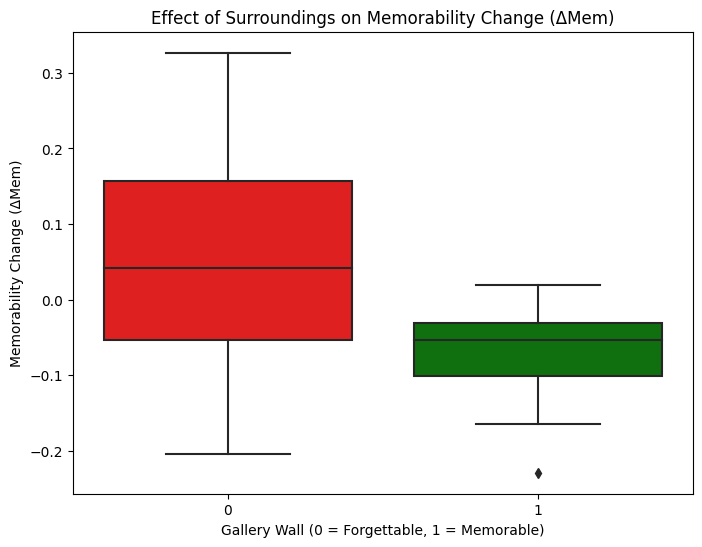

### Memorable - In-Person Scores ###

                            OLS Regression Results                            
Dep. Variable:               Bayes_IP   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     5.297
Date:                Sun, 30 Mar 2025   Prob (F-statistic):            0.00730
Time:                        19:56:23   Log-Likelihood:                 37.836
No. Observations:                  20   AIC:                            -65.67
Df Residuals:                      15   BIC:                            -60.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/Yifei/anaconda3/envs/art_contest/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Load the already merged dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/IP/IP_39_connectivity.csv"
df_merged = pd.read_csv(file_path)

# Ensure 'Wall' is properly encoded
df_merged['Wall'] = df_merged['Wall'].apply(lambda x: 1 if x in ['E', "S"] else 0)

# Function to run a regression model
def run_regression(df, dependent_var, predictors):
    """Runs OLS regression with standardized predictors and returns the model."""
    X = df[predictors].copy()
    scaler = StandardScaler()
    X[predictors] = scaler.fit_transform(X[predictors])
    
    # Add intercept
    X = sm.add_constant(X)
    y = df[dependent_var]
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    return model

# Dictionary to store regression results
regression_results = {}

# Define predictors
predictors_ols = ["Weighted Betweenness", "Euclidean Distance from Entrance", 
                  "Weighted Neighbor Area", "Weighted Neighbor OnlineMem"]

predictors_context = ["Weighted Betweenness", "Weighted Neighbor Area", 
                      "Residual_NeighborMem", "Residual_Distance"]

# ---------------------------- Multiple Regressions (All 39, Mem, Forg) ----------------------------

# Separate datasets for memorable and forgettable artworks
df_memorable = df_merged[df_merged["Wall"] == 1]
df_forgettable = df_merged[df_merged["Wall"] == 0]

# Run regressions for different groups
#regression_results["All 39 - In-Person Scores"] = run_regression(df_merged, "Bayes_IP", predictors_ols)
regression_results["Memorable - In-Person Scores"] = run_regression(df_memorable, "Bayes_IP", predictors_ols)
regression_results["Forgettable - In-Person Scores"] = run_regression(df_forgettable, "Bayes_IP", predictors_ols)

# ---------------------------- Change in Memorability (Mem vs. Forg) ----------------------------

# Compute Memorability Change (ΔMem)
df_merged["ΔMem"] = df_merged["Bayes_IP"] - df_merged["OnlineMem"]
df_memorable["ΔMem"] = df_memorable["Bayes_IP"] - df_memorable["OnlineMem"]
df_forgettable["ΔMem"] = df_forgettable["Bayes_IP"] - df_forgettable["OnlineMem"]

# Mann-Whitney U Test (non-parametric alternative to T-test)
u_stat, p_value_mwu = mannwhitneyu(df_memorable["ΔMem"], df_forgettable["ΔMem"], alternative="two-sided")

# Store Mann-Whitney U Test results
statistical_test_results = {"U-statistic": u_stat, "p-value": p_value_mwu}

# Compute relative % change (boost) for each group
mem_boost = (df_memorable["ΔMem"].mean() / df_memorable["OnlineMem"].mean()) * 100
forg_boost = (df_forgettable["ΔMem"].mean() / df_forgettable["OnlineMem"].mean()) * 100

# Boxplot to visualize ΔMem based on surrounding memorability
plt.figure(figsize=(8, 6))
sns.boxplot(x="Wall", y="ΔMem", data=df_merged, palette=["red", "green"])
plt.title("Effect of Surroundings on Memorability Change (ΔMem)")
plt.xlabel("Gallery Wall (0 = Forgettable, 1 = Memorable)")
plt.ylabel("Memorability Change (ΔMem)")
plt.show()

# ---------------------------- Online vs. IP Mem paired t-test (Mem and Forg seperately) ----------------------------

# Perform paired-sample t-test between online vs. IP Mem 
t_stat_mem, p_val_mem = ttest_rel(df_memorable["Bayes_IP"], df_memorable["OnlineMem"])
t_stat_forg, p_val_forg = ttest_rel(df_forgettable["Bayes_IP"], df_forgettable["OnlineMem"])

# ---------------------------- Residualized Regression (All 39) ----------------------------
# Residualization Step for contextual regression
X_wall = sm.add_constant(df_merged["Wall"])
df_merged["Residual_Mem"] = sm.OLS(df_merged["Bayes_IP"], X_wall).fit().resid
df_merged["Residual_NeighborMem"] = sm.OLS(df_merged["Weighted Neighbor OnlineMem"], X_wall).fit().resid
df_merged["Residual_Distance"] = sm.OLS(df_merged["Euclidean Distance from Entrance"], X_wall).fit().resid

# Contextual feature analysis after residualization
regression_results["All 39 - Contextual Features"] = run_regression(df_merged, "Residual_Mem", predictors_context)

# Display all regression summaries
for model_name, model in regression_results.items():
    print(f"### {model_name} ###\n")
    print(model.summary(), "\n\n")

# Display Mann-Whitney U Test results
print("### Mann-Whitney U Test Results ###\n")
print(f"U-statistic = {statistical_test_results['U-statistic']:.3f}, p-value = {statistical_test_results['p-value']:.5f}")

# Store T-Test results separately
t_stat, p_value = ttest_ind(df_forgettable["ΔMem"], df_memorable["ΔMem"], equal_var=False)
t_test_results = {"t-statistic": t_stat, "p-value": p_value}
print("### T-Test Results ###\n")
print(f"T-statistic = {t_test_results['t-statistic']:.3f}, p-value = {t_test_results['p-value']:.5f}")

# Print the boost values
print(f"Memorable artworks showed a {mem_boost:.1f}% boost in memory performance.")
print(f"Forgettable artworks showed a {forg_boost:.1f}% boost in memory performance.")

# Display paired t-test results for Online vs. IP Mem and Forg
print(f"Online vs. IP Mem T-statistic: {t_stat_mem:.3f}")
print(f"Online vs. IP Mem P-value: {p_val_mem:.5f}")
print(f"Online vs. IP Forg T-statistic: {t_stat_forg:.3f}")
print(f"Online vs. IP Forg P-value: {p_val_forg:.5f}")

In [121]:
# ---------------------------- Residualized Regression (!add in visual features!) ----------------------------
# Load the additional dataset containing "Area" and "Medium_" predictors
file_path_additional = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df_additional = pd.read_csv(file_path_additional)
df_additional.drop(columns=["Area"], inplace=True)
df_additional.drop(columns=["OnlineMem"], inplace=True)

# Ensure that only matching "Name" values are used (since df_additional has more rows)
df_additional_filtered = df_additional[df_additional["Name"].isin(df_merged["Name"])].copy()
print(df_additional_filtered.shape)
df_new = df_merged.merge(df_additional_filtered, on="Name", how="left")

# Residualize Bayes_IP by regressing out OnlineMem
X_online_mem = sm.add_constant(df_new["OnlineMem"])
residual_model = sm.OLS(df_new["Bayes_IP"], X_online_mem).fit()
df_new["Residual_Bayes_IP"] = residual_model.resid  # Store residuals

# Extract "Area" and all columns starting with "Medium_"
additional_cols = ["Area"] + [col for col in df_additional_filtered.columns if col.startswith("Medium_")]
vis_cols = ["Hue", "Saturation", "Luminance", "Edge_Density", "Subband_Entropy", "Spectral_Energy"]
predictors_residualized = additional_cols + vis_cols

# Run regression using residualized Bayes_IP
regression_model = run_regression(df_new, "Residual_Bayes_IP", predictors_residualized)

# Display the regression summary
print(regression_model.summary())


(39, 73)
                            OLS Regression Results                            
Dep. Variable:      Residual_Bayes_IP   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                 -0.169
Method:                 Least Squares   F-statistic:                    0.6083
Date:                Sun, 30 Mar 2025   Prob (F-statistic):              0.832
Time:                        20:38:01   Log-Likelihood:                 37.641
No. Observations:                  39   AIC:                            -45.28
Df Residuals:                      24   BIC:                            -20.33
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2

## Human Ratings:

In [95]:
import pandas as pd
import scipy.stats as stats

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Function to compute correlation matrix and p-values
def compute_correlations(df_subset, variables):
    corr_matrix = df_subset[variables].corr()
    p_matrix = pd.DataFrame(index=variables, columns=variables)

    for col1 in variables:
        for col2 in variables:
            if col1 != col2:
                r, p = stats.pearsonr(df_subset[col1].dropna(), df_subset[col2].dropna())
                p_matrix.loc[col1, col2] = p
            else:
                p_matrix.loc[col1, col2] = None
    return corr_matrix, p_matrix

# Compute correlations for OnlineMem, ResMem, Memorable, and Famous
related_vars = ["OnlineMem", "ResMem", "Memorable", "Famous"]
corr, p = compute_correlations(df, related_vars)

corr, p

(           OnlineMem    ResMem  Memorable    Famous
 OnlineMem   1.000000  0.408636   0.104924 -0.149164
 ResMem      0.408636  1.000000  -0.107902 -0.188583
 Memorable   0.104924 -0.107902   1.000000  0.798259
 Famous     -0.149164 -0.188583   0.798259  1.000000,
           OnlineMem    ResMem Memorable    Famous
 OnlineMem      None  0.000094  0.336328  0.170458
 ResMem     0.000094      None  0.322715  0.082054
 Memorable  0.336328  0.322715      None       0.0
 Famous     0.170458  0.082054       0.0      None)

In [ ]:
from scipy.stats import pearsonr

# List of features to correlate with Reconstructable
features = ["Complex", "Interesting", "Famous", "Surprise", "Content_Portraits", "Content_Cartoon_ContemporaryIllustration", "Content_Animals"]

# Compute and print correlation results
for feature in features:
    r, p = pearsonr(df["Reconstructable"], df[feature])
    print(f"Correlation with {feature}: r = {r:.3f}, p = {p:.3g}")

Correlation with Complex: r = -0.782, p = 6.54e-19
Correlation with Interesting: r = -0.458, p = 9.48e-06
Correlation with Famous: r = -0.387, p = 0.000235
Correlation with Surprise: r = -0.410, p = 8.68e-05
Correlation with Content_Portraits: r = 0.112, p = 0.305
Correlation with Content_Cartoon_ContemporaryIllustration: r = 0.140, p = 0.198
Correlation with Content_Animals: r = 0.275, p = 0.0103


In [ ]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np

# Load the dataset and filter out specific names
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

def compute_ttest(group1, group2, label1="Group1", label2="Group2"):
    n1, n2 = len(group1), len(group2)
    mean1, sd1 = group1.mean(), group1.std()
    mean2, sd2 = group2.mean(), group2.std()

    # Perform Welch’s t-test
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

    # Calculate Welch–Satterthwaite degrees of freedom
    se1_sq = sd1**2 / n1
    se2_sq = sd2**2 / n2
    df = (se1_sq + se2_sq)**2 / ((se1_sq**2 / (n1 - 1)) + (se2_sq**2 / (n2 - 1)))

    return {
        "t-statistic": t_stat,
        "p-value": p_value,
        "df": df,
        f"{label1} Mean": mean1,
        f"{label1} SD": sd1,
        f"{label2} Mean": mean2,
        f"{label2} SD": sd2
    }

# --- 1. T-test using Contest label ---
memorable_contest = df[df["Contest"] == 1]["Memorable"]
forgettable_contest = df[df["Contest"] == 0]["Memorable"]

contest_results = compute_ttest(memorable_contest, forgettable_contest, "Memorable_Contest", "Forgettable_Contest")

# --- 2. T-test using Rank label (1 = memorable, 3 = forgettable) ---
memorable_rank = df[df["Rank"] == 1]["Memorable"]
forgettable_rank = df[df["Rank"] == 3]["Memorable"]

rank_results = compute_ttest(memorable_rank, forgettable_rank, "Memorable_Rank", "Forgettable_Rank")

# --- 3. Combine results ---
t_test_summary = {
    "Contest-Based Comparison": contest_results,
    "Rank-Based Comparison": rank_results
}

# Display both sets of results
t_test_summary

{'Contest-Based Comparison': {'t-statistic': 2.680419882370189,
  'p-value': 0.011440464319177317,
  'df': 32.59225259845615,
  'Memorable_Contest Mean': 2.842250817032258,
  'Memorable_Contest SD': 0.41384125543324135,
  'Forgettable_Contest Mean': 2.4966545217916667,
  'Forgettable_Contest SD': 0.5767817987805257},
 'Rank-Based Comparison': {'t-statistic': 0.14195311965543092,
  'p-value': 0.8878695590309302,
  'df': 37.86964130449934,
  'Memorable_Rank Mean': 2.8148913832,
  'Memorable_Rank SD': 0.5086580998429343,
  'Forgettable_Rank Mean': 2.7926996934499995,
  'Forgettable_Rank SD': 0.47964080309015983}}

In [87]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# Load the dataset and filter out specific names
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Function to run a regression model
def run_regression(df, dependent_var, predictors):
    # Standardize predictors before running regression (keeping variable names)
    X = df[predictors].copy()
    scaler = StandardScaler()
    X[predictors] = scaler.fit_transform(X[predictors])
    
    # Add intercept
    X = sm.add_constant(X)
    y = df[dependent_var]
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    return model

# Run multiple regression: Which factor predicts memorability?
regression_results = {}

# Define predictors
predictors_base = ["Contest", "Education", "ProLevel"] 
regression_results["Base Model"] = run_regression(df, "Memorable", predictors_base)

# Create interaction terms for moderation models
df["Contest_Education"] = df["Contest"] * df["Education"]
df["Contest_ProLevel"] = df["Contest"] * df["ProLevel"]
df["Education_ProLevel"] = df["Education"] * df["ProLevel"]

predictors_moderation_1 = ["Contest", "Education", "Contest_Education"]
predictors_moderation_2 = ["Contest", "ProLevel", "Contest_ProLevel"]
predictors_moderation_3 = ["Contest", "Education", "ProLevel", "Contest_Education", "Contest_ProLevel", "Education_ProLevel"]

# Run moderation models
regression_results["Moderation Model 1"] = run_regression(df, "Memorable", predictors_moderation_1)
regression_results["Moderation Model 2"] = run_regression(df, "Memorable", predictors_moderation_2)
regression_results["Moderation Model 3"] = run_regression(df, "Memorable", predictors_moderation_3)

# Print all results
for model_name, model in regression_results.items():
    print(f"### {model_name} ###\n")
    print(model.summary(), "\n\n")

### Base Model ###

                            OLS Regression Results                            
Dep. Variable:              Memorable   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     6.189
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           0.000764
Time:                        12:45:54   Log-Likelihood:                -50.886
No. Observations:                  86   AIC:                             109.8
Df Residuals:                      82   BIC:                             119.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7458      0.048

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Identify predictor columns: from "Happiness" to "Human"
columns = list(df.columns)
start_idx = columns.index("Happiness")
end_idx = columns.index("Human")
predictor_columns = columns[start_idx:end_idx + 1]

#vis_cols = ["Hue", "Saturation", "Luminance", "Edge_Density", "Subband_Entropy", "Spectral_Energy"]
#predictor_all = predictor_columns + vis_cols + ["Contest", "Area", "Education", "ProLevel"] + [col for col in df.columns if "Medium_" in col] 

# Stepwise Regression Function with Standardization (criteria unchanged)
def stepwise_regression(X, y, p_in=0.05, p_out=0.10):
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    selected_vars = []
    remaining_vars = list(X_scaled.columns)

    while True:
        changed = False

        # Forward Selection
        best_pval = float("inf")
        best_var = None
        for var in remaining_vars:
            test_vars = selected_vars + [var]
            X_test = sm.add_constant(X_scaled[test_vars])
            model = sm.OLS(y, X_test).fit()
            pval = model.pvalues[var]
            if pval < p_in and pval < best_pval:
                best_pval = pval
                best_var = var

        if best_var:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
            changed = True

        # Backward Elimination
        while True:
            X_test = sm.add_constant(X_scaled[selected_vars])
            model = sm.OLS(y, X_test).fit()
            pvals = model.pvalues.iloc[1:]  # Exclude intercept
            worst_pval = pvals.max()
            if worst_pval > p_out:
                worst_var = pvals.idxmax()
                selected_vars.remove(worst_var)
                changed = True
            else:
                break

        if not changed:
            break

    # Final model
    final_X = sm.add_constant(X_scaled[selected_vars])
    final_model = sm.OLS(y, final_X).fit()
    return final_model

# Run Stepwise Regression with OnlineMem as Y
X_online = df[predictor_columns]
y_online = df["OnlineMem"]
model_online = stepwise_regression(X_online, y_online)

# Run Stepwise Regression with Memorable as Y, excluding Memorable from X
X_memorable = df[[col for col in predictor_columns if col != "Memorable"]]
y_memorable = df["Memorable"]
model_memorable = stepwise_regression(X_memorable, y_memorable)

# Show both summaries
model_online.summary(), model_memorable.summary()


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              OnlineMem   R-squared:                       0.532
 Model:                            OLS   Adj. R-squared:                  0.509
 Method:                 Least Squares   F-statistic:                     23.03
 Date:                Wed, 14 May 2025   Prob (F-statistic):           9.89e-13
 Time:                        22:23:19   Log-Likelihood:                 92.448
 No. Observations:                  86   AIC:                            -174.9
 Df Residuals:                      81   BIC:                            -162.6
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------

In [ ]:
## NOTE! No Need! ##

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Create interaction terms for moderation models
df["Reconstructable_Effortful"] = df["Reconstructable"] * df["Effortful"]
df["Reconstructable_Complex"] = df["Reconstructable"] * df["Complex"]
df["Effortful_Complex"] = df["Effortful"] * df["Complex"]

predictors_moderation_1 = ["Reconstructable", "Effortful", "Complex"]
predictors_moderation_2 = ["Reconstructable", "Effortful", "Complex", "Reconstructable_Effortful", "Reconstructable_Complex", "Effortful_Complex"]

# Run moderation models
regression_results = {}
regression_results["Moderation Model 1"] = run_regression(df, "OnlineMem", predictors_moderation_1)
regression_results["Moderation Model 2"] = run_regression(df, "OnlineMem", predictors_moderation_2)

# Print all results
for model_name, model in regression_results.items():
    print(f"### {model_name} ###\n")
    print(model.summary(), "\n\n")

### Moderation Model 1 ###

                            OLS Regression Results                            
Dep. Variable:              OnlineMem   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     18.48
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           3.00e-09
Time:                        17:19:40   Log-Likelihood:                 81.999
No. Observations:                  86   AIC:                            -156.0
Df Residuals:                      82   BIC:                            -146.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const         

## ResMem:

In [138]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Choose the column name you want stats for, e.g., "Memorable"
col = "ResMem"

# Compute descriptive statistics
mean_val = df[col].mean()
std_val = df[col].std()
min_val = df[col].min()
max_val = df[col].max()

# Print nicely
print(f"Descriptive stats for '{col}':")
print(f"  Mean:  {mean_val:.3f}")
print(f"  SD:    {std_val:.3f}")
print(f"  Min:   {min_val:.3f}")
print(f"  Max:   {max_val:.3f}")

pearsonr(df["OnlineMem"], df["ResMem"])

Descriptive stats for 'ResMem':
  Mean:  0.819
  SD:    0.083
  Min:   0.538
  Max:   0.961


PearsonRResult(statistic=0.4086355313045439, pvalue=9.381763378837297e-05)

In [9]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Standardize relevant variables
scaler = StandardScaler()
df[["ResMem_z", "Memorable_z", "OnlineMem_z"]] = scaler.fit_transform(df[["ResMem", "Memorable", "OnlineMem"]])

# --- Part 1: Regression predicting OnlineMem_z ---
X1 = sm.add_constant(df["ResMem_z"])
X2 = sm.add_constant(df["Memorable_z"])
X3 = sm.add_constant(df[["ResMem_z", "Memorable_z"]])
y = df["OnlineMem_z"]

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

regression_summaries = {
    "Model: OnlineMem ~ ResMem": model1.summary(),
    "Model: OnlineMem ~ Memorable": model2.summary(),
    "Model: OnlineMem ~ ResMem + Memorable": model3.summary()
}

# --- Part 2: Classification predicting Label (based on Rank) ---
# Create a binary label from Rank (1 = memorable, 3 = forgettable)
df_rank = df[df["Rank"].isin([1, 3])].copy()
df_rank["Label_binary"] = df_rank["Rank"].apply(lambda x: 1 if x == 1 else 0)
y_bin_rank = df_rank["Label_binary"]

clf_resmem_rank = LogisticRegression().fit(df_rank[["ResMem_z"]], y_bin_rank)
clf_memorable_rank = LogisticRegression().fit(df_rank[["Memorable_z"]], y_bin_rank)
clf_contest_rank = LogisticRegression().fit(df_rank[["Contest"]], y_bin_rank)

probs_resmem_rank = clf_resmem_rank.predict_proba(df_rank[["ResMem_z"]])[:, 1]
probs_memorable_rank = clf_memorable_rank.predict_proba(df_rank[["Memorable_z"]])[:, 1]
probs_contest_rank = clf_contest_rank.predict_proba(df_rank[["Contest"]])[:, 1]

auc_resmem_rank = roc_auc_score(y_bin_rank, probs_resmem_rank)
auc_memorable_rank = roc_auc_score(y_bin_rank, probs_memorable_rank)
auc_contest_rank = roc_auc_score(y_bin_rank, probs_contest_rank)

acc_resmem_rank = accuracy_score(y_bin_rank, clf_resmem_rank.predict(df_rank[["ResMem_z"]]))
acc_memorable_rank = accuracy_score(y_bin_rank, clf_memorable_rank.predict(df_rank[["Memorable_z"]]))
acc_contest_rank = accuracy_score(y_bin_rank, clf_contest_rank.predict(df_rank[["Contest"]]))

# --- Part 3: Classification predicting Label (based on Contest) ---
# "Contest" is already binary: 1 = memorable submission, 0 = forgettable
df_contest = df.copy()
y_bin_contest = df_contest["Contest"]

clf_resmem_contest = LogisticRegression().fit(df_contest[["ResMem_z"]], y_bin_contest)
clf_memorable_contest = LogisticRegression().fit(df_contest[["Memorable_z"]], y_bin_contest)

probs_resmem_contest = clf_resmem_contest.predict_proba(df_contest[["ResMem_z"]])[:, 1]
probs_memorable_contest = clf_memorable_contest.predict_proba(df_contest[["Memorable_z"]])[:, 1]

auc_resmem_contest = roc_auc_score(y_bin_contest, probs_resmem_contest)
auc_memorable_contest = roc_auc_score(y_bin_contest, probs_memorable_contest)

acc_resmem_contest = accuracy_score(y_bin_contest, clf_resmem_contest.predict(df_contest[["ResMem_z"]]))
acc_memorable_contest = accuracy_score(y_bin_contest, clf_memorable_contest.predict(df_contest[["Memorable_z"]]))

# Compile results
classification_results = {
    "Rank-Based Classification": {
        "ResMem": {"AUC": auc_resmem_rank, "Accuracy": acc_resmem_rank},
        "Memorable": {"AUC": auc_memorable_rank, "Accuracy": acc_memorable_rank},
        "Contest": {"AUC": auc_contest_rank, "Accuracy": acc_contest_rank}
    },
    "Contest-Based Classification": {
        "ResMem": {"AUC": auc_resmem_contest, "Accuracy": acc_resmem_contest},
        "Memorable": {"AUC": auc_memorable_contest, "Accuracy": acc_memorable_contest}
    }
}

# View the results
regression_summaries, classification_results


({'Model: OnlineMem ~ ResMem': <class 'statsmodels.iolib.summary.Summary'>
  """
                              OLS Regression Results                            
  Dep. Variable:            OnlineMem_z   R-squared:                       0.167
  Model:                            OLS   Adj. R-squared:                  0.157
  Method:                 Least Squares   F-statistic:                     16.84
  Date:                Wed, 09 Apr 2025   Prob (F-statistic):           9.38e-05
  Time:                        22:27:27   Log-Likelihood:                -114.17
  No. Observations:                  86   AIC:                             232.3
  Df Residuals:                      84   BIC:                             237.3
  Df Model:                           1                                         
  Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
  --------------------------

In [20]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]
df = df[df["Label"].isin(["Mem", "Forg"])]

# Standardize relevant variables
scaler = StandardScaler()
df[["ResMem_z", "Memorable_z", "Bayes_IP_HR_FAR_z"]] = scaler.fit_transform(df[["ResMem", "Memorable", "Bayes_IP_HR_FAR"]])

# --- Regression predicting Bayes_IP_HR_FAR_z ---
X1 = sm.add_constant(df["ResMem_z"])
X2 = sm.add_constant(df["Memorable_z"])
X3 = sm.add_constant(df[["ResMem_z", "Memorable_z"]])
y = df["Bayes_IP_HR_FAR_z"]

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

# Compile results
regression_summaries = {
    "Model: Bayes_IP ~ ResMem": model1.summary(),
    "Model: Bayes_IP ~ Memorable": model2.summary(),
    "Model: Bayes_IP ~ ResMem + Memorable": model3.summary()
}

regression_summaries


{'Model: Bayes_IP ~ ResMem': <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:      Bayes_IP_HR_FAR_z   R-squared:                       0.329
 Model:                            OLS   Adj. R-squared:                  0.311
 Method:                 Least Squares   F-statistic:                     18.13
 Date:                Sat, 22 Mar 2025   Prob (F-statistic):           0.000136
 Time:                        18:39:35   Log-Likelihood:                -47.564
 No. Observations:                  39   AIC:                             99.13
 Df Residuals:                      37   BIC:                             102.5
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------------

## Clustering Analysis:

In [116]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from itertools import combinations

# Load dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Create a binary label: 1 if Rank == 1 (memorable), 0 if Rank == 3 (forgettable)
df.loc[df["Rank"].isin([1, 3]), "Group"] = df["Rank"].map({1: 1, 3: 0})

# Define relevant features
all_columns = list(df.columns)
start_idx = all_columns.index("Happiness")
end_idx = all_columns.index("Price_RTS")
psych_columns = all_columns[start_idx:end_idx + 1]
other_columns = ["Contest", "Education", "ProLevel", "Area"]
#medium_columns = [col for col in df.columns if col.startswith("Medium_")]
feature_columns = ["Human"] + psych_columns + other_columns #+ medium_columns

# Helper function to compute purity
def compute_purity_excluding_foil(df, cluster_col="Cluster", true_label_col="Group"):
    df_eval = df[df[true_label_col].isin([0, 1])]
    contingency_matrix = pd.crosstab(df_eval[cluster_col], df_eval[true_label_col])
    return np.sum(np.max(contingency_matrix.values, axis=1)) / np.sum(contingency_matrix.values)

# PCA + KMeans + evaluation function optimizing purity
def evaluate_pca_clustering(features):
    X_selected = df[features]
    X_scaled = StandardScaler().fit_transform(X_selected)

    pca = PCA(n_components=min(len(features), X_scaled.shape[1]))
    X_pca = pca.fit_transform(X_scaled)

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    df["Cluster"] = kmeans.fit_predict(X_pca)

    purity = compute_purity_excluding_foil(df, cluster_col="Cluster", true_label_col="Group")
    return purity


In [117]:
# Evaluate different feature subsets
feature_sets = [list(combo) for combo in combinations(feature_columns, 10)]
best_set = None
best_purity = 0

for f_set in feature_sets:
    purity = evaluate_pca_clustering(f_set)
    if purity > best_purity:
        best_purity = purity
        best_set = f_set

print("Best 8-feature set based on cluster purity:", best_set)
print("Purity score of best set:", best_purity)

Best 8-feature set based on cluster purity: ['Happiness', 'Anger', 'Fear', 'Familiar', 'Complex', 'Professional', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
Purity score of best set: 0.875


Best 6-feature set based on cluster purity: ['Sadness', 'Beautiful', 'Familiar', 'Reconstructable', 'Contest', 'ProLevel']
Purity score of best set: 0.9

Best 8-feature set based on cluster purity: ['Anger', 'Fear', 'Beautiful', 'Effortful', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
Purity score of best set: 0.875

Best 10-feature set based on cluster purity: ['Happiness', 'Anger', 'Fear', 'Familiar', 'Complex', 'Professional', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
Purity score of best set: 0.875

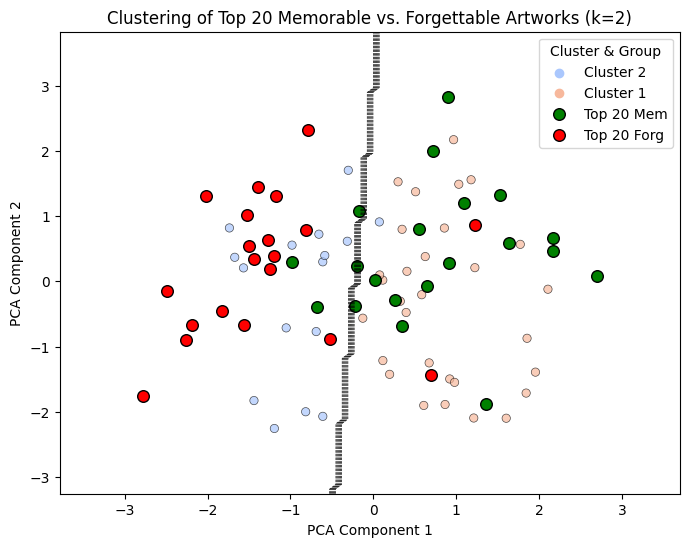


========== Top Contributing Features per PCA Component ==========

Component 1:
Reconstructable    0.702122
ProLevel          -0.488240
Familiar           0.438628
Beautiful         -0.207842
Contest            0.149116
Name: 0, dtype: float64

Component 2:
Beautiful    0.671744
Familiar     0.549245
Contest      0.403271
ProLevel     0.258090
Sadness      0.129915
Name: 1, dtype: float64

Component 3:
Sadness      0.824634
Contest      0.424396
Beautiful   -0.350440
Familiar    -0.106240
ProLevel     0.064777
Name: 2, dtype: float64

========== Variance Explained ==========
Explained Variance per Component: [0.25314577 0.22483643 0.18603851 0.1650092  0.10803691 0.06293318]
Cumulative Variance (first 3 components): 0.664

========== Cluster Purity ==========
Cluster Purity (Top vs. Bottom 20): 0.900

========== Silhouette Score ==========
Silhouette Score: 0.169


In [ ]:
# ---------------------------- Best 6-feature set ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score

# ---------------------------- Load and Clean ----------------------------
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# ---------------------------- Label Top & Bottom 20 ----------------------------
rank_to_group = {1: "Top 20 Mem", 3: "Top 20 Forg"}
df["Group"] = df["Rank"].map(rank_to_group)

# ---------------------------- Feature Selection & Standardization ----------------------------
selected_features = ['Sadness', 'Beautiful', 'Familiar', 'Reconstructable', 'Contest', 'ProLevel']
X = df[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------- PCA ----------------------------
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

# ---------------------------- KMeans Clustering ----------------------------
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_pca)
silhouette = silhouette_score(X_pca, df["Cluster"])

# ---------------------------- SVM Decision Boundary ----------------------------
svm = SVC(kernel="linear")
svm.fit(X_pca[:, :2], df["Cluster"])

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# ---------------------------- PCA Loadings ----------------------------
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns)
top_pca_features = {}
for i in range(3):
    top_features = pca_loadings.iloc[i, :].abs().sort_values(ascending=False).head(5).index
    top_pca_features[f"Component {i+1}"] = pca_loadings.loc[i, top_features]

# ---------------------------- Variance Explained ----------------------------
cumulative_variance = sum(pca.explained_variance_ratio_[:3])
explained_variance = pca.explained_variance_ratio_

# ---------------------------- Plot Clusters ----------------------------
# Get the unique cluster IDs (e.g., 0 and 1)
unique_clusters = sorted(df["Cluster"].unique())

# Create a fixed map to "Cluster 1" and "Cluster 2"
cluster_label_map = {
    unique_clusters[0]: "Cluster 1",
    unique_clusters[1]: "Cluster 2"
}

# Apply relabeling
df["ClusterLabel"] = df["Cluster"].map(cluster_label_map)
group_colors = {"Top 20 Mem": "green", "Top 20 Forg": "red"}

plt.figure(figsize=(8, 6))

# Plot decision boundary
plt.contour(xx, yy, Z, colors="black", linewidths=0.5, linestyles="dashed")

# Plot all points using cluster labels with custom names
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df["ClusterLabel"],   # Use new labeled column
    palette="coolwarm", 
    alpha=0.7, 
    edgecolor="black"
)

# Overlay Group points (Top 20 Mem / Forg)
for group, color in group_colors.items():
    subset = df[df["Group"] == group]
    plt.scatter(
        X_pca[df["Group"] == group, 0],
        X_pca[df["Group"] == group, 1],
        color=color,
        label=group,
        edgecolor="black",
        s=70
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Clustering of Top 20 Memorable vs. Forgettable Artworks (k={optimal_k})")
plt.legend(title="Cluster & Group")
plt.show()

# ---------------------------- Compute Purity ----------------------------
def compute_purity(df, cluster_col, true_label_col):
    df_filtered = df[df[true_label_col].isin(["Top 20 Mem", "Top 20 Forg"])]
    total_samples = len(df_filtered)
    correct_assignments = 0
    for cluster in df_filtered[cluster_col].unique():
        cluster_subset = df_filtered[df_filtered[cluster_col] == cluster]
        dominant_label = cluster_subset[true_label_col].value_counts().idxmax()
        correct_assignments += sum(cluster_subset[true_label_col] == dominant_label)
    return correct_assignments / total_samples

purity_score = compute_purity(df, cluster_col="Cluster", true_label_col="Group")

# ---------------------------- Print Outputs ----------------------------
print("\n========== Top Contributing Features per PCA Component ==========")
for comp, features in top_pca_features.items():
    print(f"\n{comp}:")
    print(features)

print("\n========== Variance Explained ==========")
print("Explained Variance per Component:", explained_variance)
print(f"Cumulative Variance (first 3 components): {cumulative_variance:.3f}")

print("\n========== Cluster Purity ==========")
print(f"Cluster Purity (Top vs. Bottom 20): {purity_score:.3f}")

print("\n========== Silhouette Score ==========")
print(f"Silhouette Score: {silhouette:.3f}")

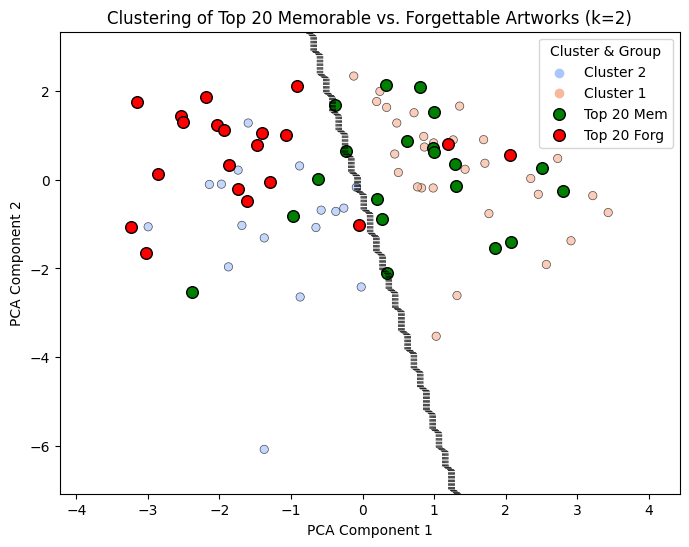


========== Top Contributing Features per PCA Component ==========

Component 1:
Effortful         -0.549716
Reconstructable    0.478083
Price_RTS         -0.408649
ProLevel          -0.327342
Fear              -0.323071
Name: 0, dtype: float64

Component 2:
Anger       -0.592120
Beautiful    0.551799
Fear        -0.504535
Price_RTS    0.241330
ProLevel     0.149733
Name: 1, dtype: float64

Component 3:
Contest           -0.863950
Beautiful         -0.295071
ProLevel           0.276348
Fear              -0.184644
Reconstructable   -0.162457
Name: 2, dtype: float64

========== Variance Explained ==========
Explained Variance per Component: [0.34542088 0.2540648  0.14250954 0.10640982 0.07514512 0.03862165
 0.02503314 0.01279506]
Cumulative Variance (first 3 components): 0.742

========== Cluster Purity ==========
Cluster Purity (Top vs. Bottom 20): 0.875

========== Silhouette Score ==========
Silhouette Score: 0.234


In [68]:
# ---------------------------- Best 8-feature set ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score

# ---------------------------- Load and Clean ----------------------------
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# ---------------------------- Label Top & Bottom 20 ----------------------------
rank_to_group = {1: "Top 20 Mem", 3: "Top 20 Forg"}
df["Group"] = df["Rank"].map(rank_to_group)

# ---------------------------- Feature Selection & Standardization ----------------------------
#selected_features = ['Human', 'Happiness', 'Effortful', 'Reconstructable', 'Price_RTS', 'Contest', 'Hue', 'Subband_Entropy']
#selected_features = ['Fear', 'Disgust', 'Interesting', 'Familiar', 'Authentic', 'Reconstructable', 'Price_RTS', 'ProLevel']
selected_features = ['Anger', 'Fear', 'Beautiful', 'Effortful', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
#selected_features = ['Human', 'Happiness', 'Effortful', 'Reconstructable', 'Price_RTS', 'Hue', 'Saturation', 'Subband_Entropy']
X = df[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------- PCA ----------------------------
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

# ---------------------------- Flip PCA Components (for interpretability) ----------------------------
# Flip first 3 PCA components to align positively with memorability features
components_to_flip = [0, 1, 2]  # Component 1 = index 0, etc.

for i in components_to_flip:
    pca.components_[i] *= -1  # Flip PCA loadings
    X_pca[:, i] *= -1         # Flip projected data

# ---------------------------- KMeans Clustering ----------------------------
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_pca)
silhouette = silhouette_score(X_pca, df["Cluster"])

# ---------------------------- SVM Decision Boundary ----------------------------
svm = SVC(kernel="linear")
svm.fit(X_pca[:, :2], df["Cluster"])

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# ---------------------------- PCA Loadings ----------------------------
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns)
top_pca_features = {}
for i in range(3):
    top_features = pca_loadings.iloc[i, :].abs().sort_values(ascending=False).head(5).index
    top_pca_features[f"Component {i+1}"] = pca_loadings.loc[i, top_features]

# ---------------------------- Variance Explained ----------------------------
cumulative_variance = sum(pca.explained_variance_ratio_[:3])
explained_variance = pca.explained_variance_ratio_

# ---------------------------- Plot Clusters ----------------------------
# Get the unique cluster IDs (e.g., 0 and 1)
unique_clusters = sorted(df["Cluster"].unique())

# Create a fixed map to "Cluster 1" and "Cluster 2"
cluster_label_map = {
    unique_clusters[0]: "Cluster 1",
    unique_clusters[1]: "Cluster 2"
}

# Apply relabeling
df["ClusterLabel"] = df["Cluster"].map(cluster_label_map)
group_colors = {"Top 20 Mem": "green", "Top 20 Forg": "red"}

plt.figure(figsize=(8, 6))

# Plot decision boundary
plt.contour(xx, yy, Z, colors="black", linewidths=0.5, linestyles="dashed")

# Plot all points using cluster labels with custom names
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df["ClusterLabel"],   # Use new labeled column
    palette="coolwarm", 
    alpha=0.7, 
    edgecolor="black"
)

# Overlay Group points (Top 20 Mem / Forg)
for group, color in group_colors.items():
    subset = df[df["Group"] == group]
    plt.scatter(
        X_pca[df["Group"] == group, 0],
        X_pca[df["Group"] == group, 1],
        color=color,
        label=group,
        edgecolor="black",
        s=70
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Clustering of Top 20 Memorable vs. Forgettable Artworks (k={optimal_k})")
plt.legend(title="Cluster & Group")
plt.show()

# ---------------------------- Compute Purity ----------------------------
def compute_purity(df, cluster_col, true_label_col):
    df_filtered = df[df[true_label_col].isin(["Top 20 Mem", "Top 20 Forg"])]
    total_samples = len(df_filtered)
    correct_assignments = 0
    for cluster in df_filtered[cluster_col].unique():
        cluster_subset = df_filtered[df_filtered[cluster_col] == cluster]
        dominant_label = cluster_subset[true_label_col].value_counts().idxmax()
        correct_assignments += sum(cluster_subset[true_label_col] == dominant_label)
    return correct_assignments / total_samples

purity_score = compute_purity(df, cluster_col="Cluster", true_label_col="Group")

# ---------------------------- Print Outputs ----------------------------
print("\n========== Top Contributing Features per PCA Component ==========")
for comp, features in top_pca_features.items():
    print(f"\n{comp}:")
    print(features)

print("\n========== Variance Explained ==========")
print("Explained Variance per Component:", explained_variance)
print(f"Cumulative Variance (first 3 components): {cumulative_variance:.3f}")

print("\n========== Cluster Purity ==========")
print(f"Cluster Purity (Top vs. Bottom 20): {purity_score:.3f}")

print("\n========== Silhouette Score ==========")
print(f"Silhouette Score: {silhouette:.3f}")


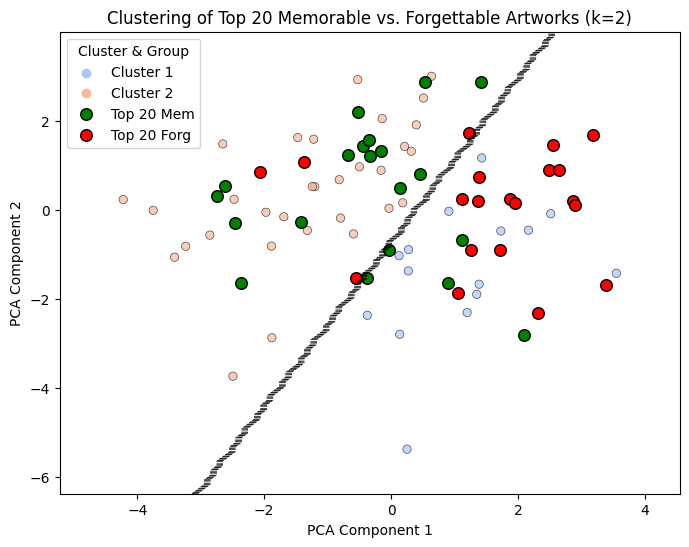


========== Top Contributing Features per PCA Component ==========

Component 1:
Complex            0.516008
Professional       0.447328
Price_RTS          0.431668
Reconstructable   -0.421950
ProLevel           0.310733
Name: 0, dtype: float64

Component 2:
Happiness       0.542485
Anger          -0.535810
Fear           -0.504491
Professional    0.261848
Familiar        0.238785
Name: 1, dtype: float64

Component 3:
Familiar           0.613966
Contest            0.528700
Reconstructable    0.392612
Fear               0.259655
Anger              0.212707
Name: 2, dtype: float64

========== Variance Explained ==========
Explained Variance per Component: [0.31318243 0.2432992  0.13184632 0.10161527 0.07070817 0.05290607
 0.03777479 0.02773645 0.01346105 0.00747025]
Cumulative Variance (first 3 components): 0.688

========== Cluster Purity ==========
Cluster Purity (Top vs. Bottom 20): 0.875

========== Silhouette Score ==========
Silhouette Score: 0.195


In [3]:
# ---------------------------- Best 10-feature set ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score

# ---------------------------- Load and Clean ----------------------------
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# ---------------------------- Label Top & Bottom 20 ----------------------------
rank_to_group = {1: "Top 20 Mem", 3: "Top 20 Forg"}
df["Group"] = df["Rank"].map(rank_to_group)

# ---------------------------- Feature Selection & Standardization ----------------------------
selected_features = ['Happiness', 'Anger', 'Fear', 'Familiar', 'Complex', 'Professional', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
X = df[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------- PCA ----------------------------
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

# ---------------------------- KMeans Clustering ----------------------------
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_pca)
silhouette = silhouette_score(X_pca, df["Cluster"])

# ---------------------------- SVM Decision Boundary ----------------------------
svm = SVC(kernel="linear")
svm.fit(X_pca[:, :2], df["Cluster"])

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# ---------------------------- PCA Loadings ----------------------------
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns)
top_pca_features = {}
for i in range(3):
    top_features = pca_loadings.iloc[i, :].abs().sort_values(ascending=False).head(5).index
    top_pca_features[f"Component {i+1}"] = pca_loadings.loc[i, top_features]

# ---------------------------- Variance Explained ----------------------------
cumulative_variance = sum(pca.explained_variance_ratio_[:3])
explained_variance = pca.explained_variance_ratio_

# ---------------------------- Plot Clusters ----------------------------
# Get the unique cluster IDs (e.g., 0 and 1)
unique_clusters = sorted(df["Cluster"].unique())

# Create a fixed map to "Cluster 1" and "Cluster 2"
cluster_label_map = {
    unique_clusters[0]: "Cluster 1",
    unique_clusters[1]: "Cluster 2"
}

# Apply relabeling
df["ClusterLabel"] = df["Cluster"].map(cluster_label_map)
group_colors = {"Top 20 Mem": "green", "Top 20 Forg": "red"}

plt.figure(figsize=(8, 6))

# Plot decision boundary
plt.contour(xx, yy, Z, colors="black", linewidths=0.5, linestyles="dashed")

# Plot all points using cluster labels with custom names
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df["ClusterLabel"],   # Use new labeled column
    palette="coolwarm", 
    alpha=0.7, 
    edgecolor="black"
)

# Overlay Group points (Top 20 Mem / Forg)
for group, color in group_colors.items():
    subset = df[df["Group"] == group]
    plt.scatter(
        X_pca[df["Group"] == group, 0],
        X_pca[df["Group"] == group, 1],
        color=color,
        label=group,
        edgecolor="black",
        s=70
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Clustering of Top 20 Memorable vs. Forgettable Artworks (k={optimal_k})")
plt.legend(title="Cluster & Group")
plt.show()

# ---------------------------- Compute Purity ----------------------------
def compute_purity(df, cluster_col, true_label_col):
    df_filtered = df[df[true_label_col].isin(["Top 20 Mem", "Top 20 Forg"])]
    total_samples = len(df_filtered)
    correct_assignments = 0
    for cluster in df_filtered[cluster_col].unique():
        cluster_subset = df_filtered[df_filtered[cluster_col] == cluster]
        dominant_label = cluster_subset[true_label_col].value_counts().idxmax()
        correct_assignments += sum(cluster_subset[true_label_col] == dominant_label)
    return correct_assignments / total_samples

purity_score = compute_purity(df, cluster_col="Cluster", true_label_col="Group")

# ---------------------------- Print Outputs ----------------------------
print("\n========== Top Contributing Features per PCA Component ==========")
for comp, features in top_pca_features.items():
    print(f"\n{comp}:")
    print(features)

print("\n========== Variance Explained ==========")
print("Explained Variance per Component:", explained_variance)
print(f"Cumulative Variance (first 3 components): {cumulative_variance:.3f}")

print("\n========== Cluster Purity ==========")
print(f"Cluster Purity (Top vs. Bottom 20): {purity_score:.3f}")

print("\n========== Silhouette Score ==========")
print(f"Silhouette Score: {silhouette:.3f}")


In [137]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Load and filter dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Define the 8-feature set
features_8 = ['Anger', 'Fear', 'Beautiful', 'Effortful', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
X_raw = df[features_8]
y = df['OnlineMem']

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=features_8, index=df.index)

# Add intercept for statsmodels
X_scaled = sm.add_constant(X_scaled)

# Fit regression model using statsmodels
model = sm.OLS(y, X_scaled).fit()

# Store predictions
df['Pred_8FeatureModel'] = model.predict(X_scaled)

# Correlation with ResMem and Human Mem
resmem = df['ResMem']
human = df['Memorable']
corr_resmem, p_resmem = pearsonr(df['Pred_8FeatureModel'], resmem)
corr_human, p_human = pearsonr(df['Pred_8FeatureModel'], human)

# Print model summary
print(model.summary())

# Print correlations
print(df['Pred_8FeatureModel'].describe()) 
print(f"\nCorrelation with ResMem: r = {corr_resmem:.3f}, p = {p_resmem:.5f}")
print(f"Correlation with Human Mem: r = {corr_human:.3f}, p = {p_human:.5f}")


                            OLS Regression Results                            
Dep. Variable:              OnlineMem   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     9.530
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           4.58e-09
Time:                        22:50:50   Log-Likelihood:                 89.383
No. Observations:                  86   AIC:                            -160.8
Df Residuals:                      77   BIC:                            -138.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8382      0.010     

In [20]:
import pandas as pd
from scipy.stats import pearsonr

# Load your dataset
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]
df_corr = df[["Price_RTS", "Complex"]].dropna()

# Calculate Pearson correlation
r, p = pearsonr(df_corr["Price_RTS"], df_corr["Complex"])

# Print results
print(f"Correlation between estimated price and complexity: r = {r:.2f}, p = {p:.4f}")

Correlation between estimated price and complexity: r = 0.57, p = 0.0000


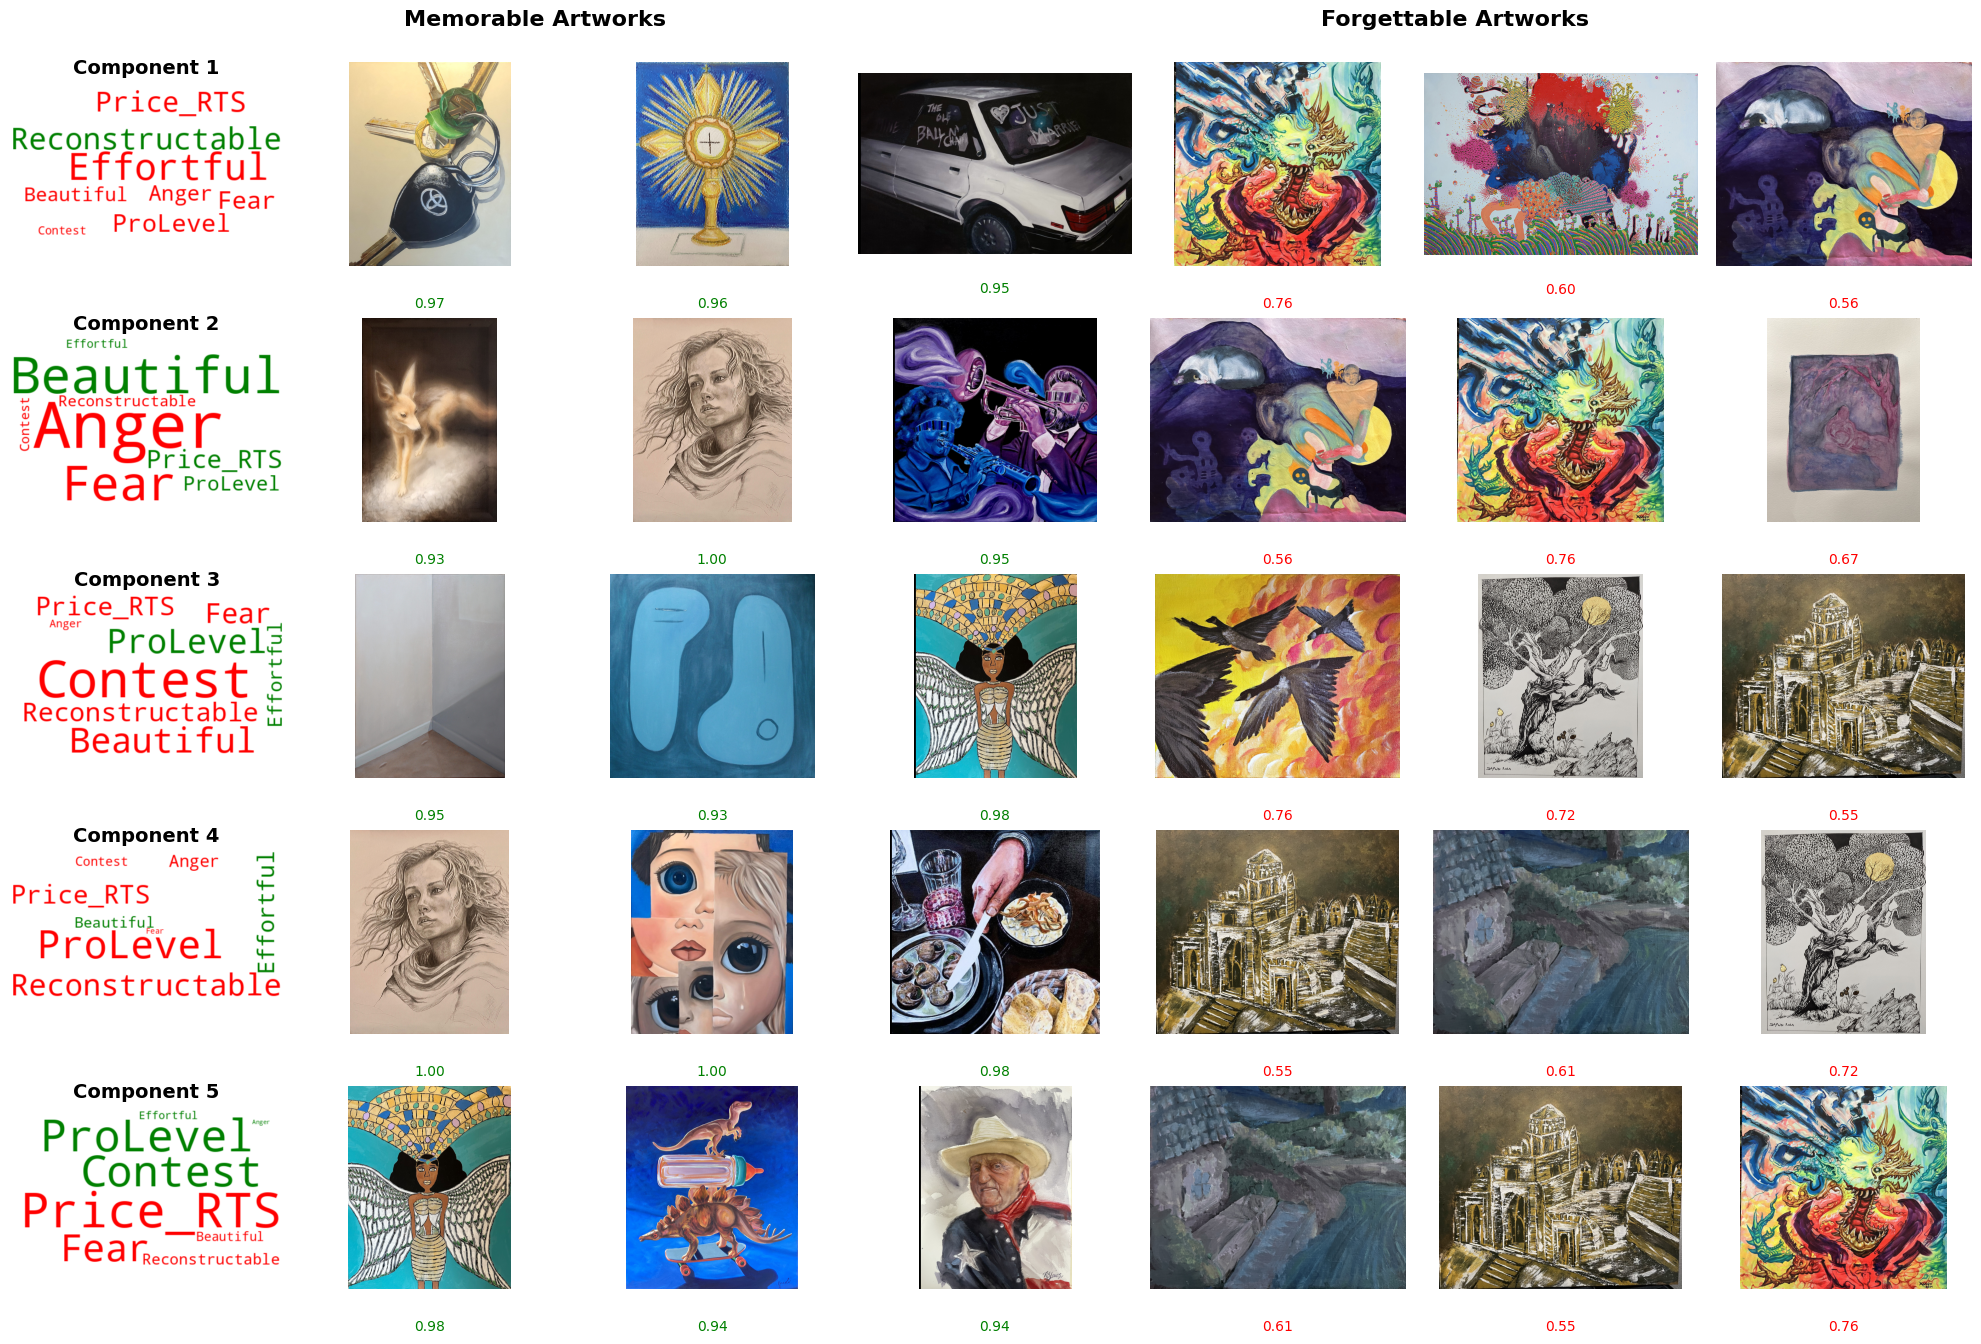

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
import os
import numpy as np
from wordcloud import WordCloud

# Load the data
file_path = "/Users/Yifei/ARTCONTEST/Analyses/data/All_Predictors.csv"
df = pd.read_csv(file_path)
df = df[~df["Name"].isin(["Dan - Forget", "Dan - Mem", "Trent - Mem", "Trent - Forget"])]

# Feature selection and scale
selected_features = ['Anger', 'Fear', 'Beautiful', 'Effortful', 'Reconstructable', 'Price_RTS', 'Contest', 'ProLevel']
X = df[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Flip first 5 PCA components
for i in range(5):
    pca.components_[i] *= -1
    X_pca[:, i] *= -1

# Top features per component
top_features_per_component = {}
for i in range(5):
    loadings = pca.components_[i]
    feature_names = np.array(selected_features)
    sorted_indices = np.argsort(np.abs(loadings))[::-1]
    top_features = feature_names[sorted_indices]
    top_values = loadings[sorted_indices]
    top_features_per_component[i] = list(zip(top_features, top_values))

# Assign scores from each component
for i in range(5):
    df[f"PC{i+1}"] = X_pca[:, i]

# Collect top images from Top 20 Mem and Top 20 Forg
top_images_pos = {}
top_images_neg = {}

for i in range(5):
    mem_df = df[df["Group"] == "Top 20 Mem"].sort_values(f"PC{i+1}", ascending=False).head(3)
    forg_df = df[df["Group"] == "Top 20 Forg"].sort_values(f"PC{i+1}", ascending=True).head(3)
    top_images_pos[i] = mem_df[["Image_Num", "OnlineMem"]].values.tolist()
    top_images_neg[i] = forg_df[["Image_Num", "OnlineMem"]].values.tolist()

# === Plotting ===
image_dir = "/Users/Yifei/ARTCONTEST/90 Images/"
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 14))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for row in range(5):
    # Word Cloud
    wc_data = {}
    color_func = {}
    for word, weight in top_features_per_component[row]:
        wc_data[word] = abs(weight)
        color_func[word] = "green" if weight > 0 else "red"
    def color_function(word, *args, **kwargs):
        return color_func.get(word, "gray")
    wc = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(wc_data)
    ax_wc = axes[row, 0]
    ax_wc.imshow(wc.recolor(color_func=color_function), interpolation='bilinear')
    ax_wc.axis("off")
    ax_wc.set_title(f"Component {row+1}", fontsize=14, weight="bold")

    # Plot Memorable (left)
    for col, (img_num, score) in enumerate(top_images_pos[row]):
        ax = axes[row, col + 1]
        img_path = os.path.join(image_dir, f"image ({int(img_num)}).jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, f"Missing\n{img_num}", ha="center", va="center")
        ax.axis("off")
        ax.text(0.5, -0.15, f"{score:.2f}", transform=ax.transAxes,
                ha='center', va='top', fontsize=10, color="green")

    # Plot Forgettable (right)
    for col, (img_num, score) in enumerate(top_images_neg[row]):
        ax = axes[row, col + 4]
        img_path = os.path.join(image_dir, f"image ({int(img_num)}).jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, f"Missing\n{img_num}", ha="center", va="center")
        ax.axis("off")
        ax.text(0.5, -0.15, f"{score:.2f}", transform=ax.transAxes,
                ha='center', va='top', fontsize=10, color="red")

# Vertical separator line between panels
for row in range(5):
    axes[row, 3].axvline(x=1.0, color="black", linewidth=2)

# Add overarching text labels
fig.text(0.27, 0.94, "Memorable Artworks", ha="center", fontsize=16, weight="bold")
fig.text(0.73, 0.94, "Forgettable Artworks", ha="center", fontsize=16, weight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
